In [1]:
!pip install scikit-learn==0.24 --user

     |████████████████████████████████| 22.3 MB 843 kB/s eta 0:00:01
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

kmeans-smote 0.1.2 requires imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.7.0 which is incompatible.
kmeans-smote 0.1.2 requires numpy<1.16,>=1.13, but you'll have numpy 1.18.5 which is incompatible.
kmeans-smote 0.1.2 requires scikit-learn<0.21,>=0.19.0, but you'll have scikit-learn 0.24.0 which is incompatible.
hypertools 0.6.2 requires scikit-learn<0.22,>=0.19.1, but you'll have scikit-learn 0.24.0 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import sklearn
sklearn.__version__

'0.24.0'

In [3]:
import pandas as pd
import numpy as np

# Read all data and set hn as index

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/plenoi/Clinic/master/ultima_all_clean.csv')
df = df.set_index('hn')
df.head()

,age,parity,hiv,menopaus,disease,surgery,conization,OPDsize,appearance,stage,...,nodeyiel,RHlvsi,depth,size,utmet,vgmargin,vgmet,pelvicme,pmmet,adnmet
hn,,,,,,,,,,,,,,,,,,,,,
2631840,52,3,0.0,0.0,1,1,0.0,5.0,4.0,5.0,...,21.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2633481,32,2,0.0,0.0,0,1,0.0,5.0,1.0,5.0,...,11.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,2.0
2634477,52,2,0.0,0.0,0,0,0.0,5.0,NaN,5.0,...,35.0,6.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2633633,38,2,0.0,0.0,0,0,0.0,2.0,1.0,4.0,...,20.0,16.0,3.0,3.8,0.0,0.0,0.0,0.0,0.0,2.0
2630496,55,3,0.0,1.0,0,0,1.0,0.0,5.0,4.0,...,17.0,9.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Data Preprocessing

Check number of data

In [5]:
df.shape

(1723, 23)

Check any missing data in each column

In [6]:
df.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
appearance    101
stage          24
pchemo          1
Wardsize      145
finalhisto     10
nodeyiel       12
RHlvsi        366
depth         489
size          114
utmet          98
vgmargin       96
vgmet          97
pelvicme        1
pmmet          94
adnmet          7
dtype: int64

Delete column with missing data

In [7]:
df_clean_column = df.drop(['appearance','Wardsize','RHlvsi','depth','nodeyiel','vgmargin','pelvicme','adnmet'],axis = 1)
df_clean_column.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
stage          24
pchemo          1
finalhisto     10
size          114
utmet          98
vgmet          97
pmmet          94
dtype: int64

Delete row with at least 1 missing data

In [8]:
df_clean = df_clean_column.dropna(axis = 0)

Total Clean Data

In [9]:
df_clean.shape

(1555, 15)

Check number of sample in pmmet class 

In [10]:
pel_class = np.unique(df_clean['pmmet'])
pel_class

array([0., 1.])

In [11]:
pel_value = [sum(df_clean['pmmet']==pel_class[0]),
             sum(df_clean['pmmet']==pel_class[1])]
pel_value

[1278, 277]

Separate pelviceme dataset into data (X) and label (y)

In [12]:
y = df_clean['pmmet'].values
X = df_clean.drop(['pmmet'],axis = 1).values

In [13]:
np.shape(y)

(1555,)

In [14]:
np.shape(X)

(1555, 14)

Separate Data into Train & Test (Note: Imbalance Dataset)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

### Pipeline Example

In [16]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA

#sm = SMOTE(random_state=1)
#X_res, y_res = sm.fit_resample(X_train, y_train)

params = {'C': [1, 2, 4, 8, 16]}
from sklearn.pipeline import Pipeline
clf = Pipeline([
  ('feature_reduction',  PCA(n_components = 12)),
  ('scaler', MinMaxScaler(feature_range=(0, 1))),
  ('feature_selection',SelectKBest(f_regression, k=10)),
  ('feature_fwd', SequentialFeatureSelector(LogisticRegression(random_state=0, solver='liblinear') , n_features_to_select=8)),
  ('classification',  GridSearchCV(LogisticRegression(random_state=0, solver='liblinear'),params, cv=5))
])
clf.fit(X_train, y_train)

Pipeline(steps=[('feature_reduction', PCA(n_components=12)),
                ('scaler', MinMaxScaler()),
                ('feature_selection',
                 SelectKBest(score_func=<function f_regression at 0x7f45706743b0>)),
                ('feature_fwd',
                 SequentialFeatureSelector(estimator=LogisticRegression(random_state=0,
                                                                        solver='liblinear'),
                                           n_features_to_select=8)),
                ('classification',
                 GridSearchCV(cv=5,
                              estimator=LogisticRegression(random_state=0,
                                                           solver='liblinear'),
                              param_grid={'C': [1, 2, 4, 8, 16]}))])

In [17]:
from sklearn.model_selection import cross_val_score
acc = cross_val_score(clf, X_train, y_train, cv=10)
print("10CV Training Accuracy : "+str(acc.mean()))

10CV Training Accuracy : 0.8272129032258064


In [18]:
yp = clf.predict(X_test)
acc =   sum(yp == y_test)/len(y_test)
print("Test Training Accuracy : "+str(acc))

Test Training Accuracy : 0.8520900321543409


In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train_pca)
X_train_norm = scaler.transform(X_train_pca)
X_test_norm = scaler.transform(X_test_pca)

In [20]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2)
tsne.fit(X_train)
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train_tsne)
X_train_norm = scaler.transform(X_train_tsne)
X_test_norm = scaler.transform(X_test_tsne)

# Logistic Regression 

10-Folds Cross Validation Training Accuracy with Tuning

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {'C': [1, 2, 4, 8, 16]}
clf = GridSearchCV(LogisticRegression(random_state=0, solver='liblinear'),params, cv=10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 1}
10CV accuracy : 81.99483870967741


Test Accuracy

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
print("Test accuracy : "+str(sum(y_test == y_predict)/len(y_test)*100))

Test accuracy : 82.95819935691318


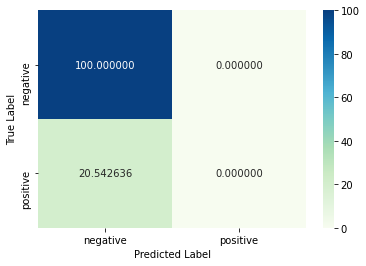

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt="f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

The precision is the ratio tp / (tp + fp). The precision is the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn). The recall is the ability of the classifier to find all the positive samples.

The F score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The support is the number of occurrences of each class in y_true.

In [24]:
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.83      1.00      0.91       258
    positive       0.00      0.00      0.00        53

    accuracy                           0.83       311
   macro avg       0.41      0.50      0.45       311
weighted avg       0.69      0.83      0.75       311



/root/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Support Vector Machine

10-Folds Cross Validation Training Accuracy

In [67]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
params = {
    'C' : [1,2,4,8,16,32], # High C = Overfitting
    'gamma' : [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32] # High gamma = Overfitting
}
clf = GridSearchCV(SVC(),params, cv=10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 32, 'gamma': 32}
10CV accuracy : 82.07483870967742


Test Accuracy

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
sum(y_test == y_predict)/len(y_test)

0.8295819935691319

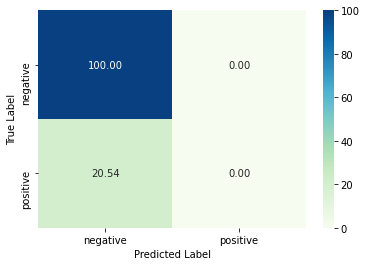

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [28]:
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.83      1.00      0.91       258
    positive       0.00      0.00      0.00        53

    accuracy                           0.83       311
   macro avg       0.41      0.50      0.45       311
weighted avg       0.69      0.83      0.75       311



/root/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Assignment**

In [112]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import SVC

sm = SMOTE(random_state=1)
X_res, y_res = sm.fit_resample(X_train, y_train)

params = {  'C' : [1,2,4,8,16,32], 
            'gamma' : [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32],}

from sklearn.pipeline import Pipeline
clf = Pipeline([
  ('scaler', MinMaxScaler(feature_range=(0, 1))),
  ('feature_selection', SelectKBest(f_classif, k=5)),
  ('classification', GridSearchCV(SVC(),params, cv=10))
])
clf.fit(X_res, y_res)





Pipeline(steps=[('scaler', MinMaxScaler()),
                ('feature_selection', SelectKBest(k=5)),
                ('classification',
                 GridSearchCV(cv=10, estimator=SVC(),
                              param_grid={'C': [1, 2, 4, 8, 16, 32],
                                          'gamma': [0.03125, 0.0625, 0.125,
                                                    0.25, 0.5, 1, 2, 4, 8, 16,
                                                    32]}))])

In [113]:
from sklearn.model_selection import cross_val_score
acc = cross_val_score(clf, X_train, y_train, cv=10)
print("10CV Training Accuracy : "+str(acc.mean()))


10CV Training Accuracy : 0.8304451612903225


In [114]:
yp = clf.predict(X_test)
acc =   sum(yp == y_test)/len(y_test)
print("Test Training Accuracy : "+str(acc))

Test Training Accuracy : 0.729903536977492
